### Producing distance plots from the ICU20201 sensor outputs

In [33]:
import os
import pandas as pd
import numpy as np
import io
import re
import matplotlib.pyplot as plt

DATAPATH = "data/helbling_rock_test/"
MATERIAL = "natural-rock"
MEDIUM = "water"
FREQ = 25.64

Function to parse one file

In [23]:
import pandas as pd
import numpy as np
import io

def analyze_range_stats(filepath, material, medium, frequency, distance):
    """
    Parses a sensor data file and computes statistics on the measured range.

    Args:
        filepath (str): Path to the .txt file (CSV-formatted).
        material (str): Type of material (e.g., "rock").
        medium (str): Surrounding medium (e.g., "water").
        frequency (float): Frequency in Hz (e.g., 2564.0).
        distance (float): Ground truth distance in cm.

    Returns:
        dict: Summary with mean, std deviation, mean absolute error, and number of readings.
    """
    # Find the header line
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_line_index = None
    for i, line in enumerate(lines):
        if line.startswith("# time [s],tx_id"):
            header_line_index = i
            break

    if header_line_index is None:
        raise ValueError("Header line with 'range [cm]' not found.")

    # Parse header and read data
    header_line = lines[header_line_index].lstrip("#").strip()
    columns = [col.strip() for col in header_line.split(',')]
    data_lines = lines[header_line_index + 1:]
    df = pd.read_csv(io.StringIO("".join(data_lines)), names=columns)

    # Extract and clean 'range [cm]'
    if 'range [cm]' not in df.columns:
        raise ValueError("'range [cm]' column not found in file.")
    
    range_values = df['range [cm]'].dropna()

    # Compute statistics
    mean_range = range_values.mean()
    std_range = range_values.std()
    abs_error = np.abs(range_values - distance).mean()
    num_readings = len(range_values)

    return {
        "material": material,
        "medium": medium,
        "frequency_hz": frequency,
        "ground_truth_cm": distance,
        "mean_range_cm": float(mean_range),
        "std_dev_cm": float(std_range),
        "mean_absolute_error_cm": float(abs_error),
        "num_readings": int(num_readings)
    }


In [24]:
# Sample usage
result = analyze_range_stats(
    filepath=DATAPATH + "water-natural-rock-2564hz-340mm_SmartSonic2AM_2025-07-28_15-01-02.txt",
    material=MATERIAL,
    medium=MEDIUM,
    frequency=FREQ,
    distance=34.0
)

print(result)

{'material': 'natural-rock', 'medium': 'water', 'frequency_hz': 25.64, 'ground_truth_cm': 34.0, 'mean_range_cm': 36.17072024508271, 'std_dev_cm': 0.03407893991783425, 'mean_absolute_error_cm': 2.170720245082712, 'num_readings': 99}


Finding all files to parse

In [22]:
# Distances are hard-coded for now, but can be parameterized later
DISTANCES = [340, 390, 440, 490, 540, 590, 640, 690, 740, 790, 840, 880]

In [28]:
# Relies on having one reading per distance
def get_distance_file_map(data_folder, distances):
    """
    Collects valid data file paths for each target distance.

    Args:
        data_folder (str): Folder path containing the data files.
        distances (list[int]): Distances in mm to match in filenames.

    Returns:
        dict[int, list[str]]: Mapping from distance (mm) to list of file paths.
    """
    distance_file_map = {d: [] for d in distances}

    for fname in os.listdir(data_folder):
        if not fname.endswith('.txt'):
            continue
        if fname.endswith('algo.txt'):
            continue

        for d in distances:
            if f"{d}mm" in fname:
                full_path = os.path.join(data_folder, fname)
                distance_file_map[d].append(full_path)
                break  # Avoid double-adding to multiple distances

    return distance_file_map

# Building the full file map
file_map = get_distance_file_map(DATAPATH, DISTANCES)

In [30]:
# Verifying the right files are collected
print("340mm files:", file_map[340])
print("740mm files:", file_map[740])


340mm files: ['data/helbling_rock_test/water-natural-rock-2564hz-340mm_SmartSonic2AM_2025-07-28_15-01-02.txt']
740mm files: ['data/helbling_rock_test/water-natural-rock-2564hz-740mm_SmartSonic2AM_2025-07-28_15-06-35.txt']


In [31]:
# Gathering all the data from each distance
mean_ranges = []
absolute_differences = []
standard_deviations = []

for dist in DISTANCES:
    files = file_map[dist]
    for fpath in files:
        result = analyze_range_stats(
            filepath=fpath,
            material=MATERIAL,
            medium=MEDIUM,
            frequency=FREQ,
            distance=dist / 10.0  # convert mm to cm
        )
        mean_ranges.append(result["mean_range_cm"])
        absolute_differences.append(result["mean_absolute_error_cm"])
        standard_deviations.append(result["std_dev_cm"])

print("Mean Ranges (cm):", mean_ranges)
print("Mean Absolute Errors (cm):", absolute_differences)
print("Standard Deviations (cm):", standard_deviations)

Mean Ranges (cm): [36.17072024508271, 38.25416355394941, 43.33255900723283, 48.583765492180916, 53.41705329526529, 58.76456370695468, 64.16447441942626, 71.57447512238733, 73.23681887877105, 78.75686826125451, 85.36864102874176, 94.36042389507875]
Mean Absolute Errors (cm): [2.170720245082712, 0.7458364460505811, 0.6674409927671737, 0.41623450781909316, 0.5838499968585645, 0.23543629304530986, 0.26591067450274986, 2.574475122387325, 0.7631811212289479, 0.24313173874547464, 1.3686410287417647, 6.360423895078754]
Standard Deviations (cm): [0.03407893991783425, 0.06831805980369665, 0.0389371018365916, 0.03209723360418563, 2.5295451366800377, 0.05315589008693998, 0.26274704974470015, 0.33822563316419835, 0.053040124073748696, 0.0935343187822349, 0.17910894695618176, 0.13695614000540846]


For storage and retrieval of analyzed data, to avoid repeating computations

In [32]:
output_dir = "data/analyzed_helbling_rock_test"
os.makedirs(output_dir, exist_ok=True)

# Build a DataFrame
df = pd.DataFrame({
    "distance_mm": DISTANCES,
    "mean_range_cm": mean_ranges,
    "mean_absolute_error_cm": absolute_differences,
    "std_dev_cm": standard_deviations,
    "material": MATERIAL,
    "medium": MEDIUM,
    "frequency_hz": FREQ
})

# Save as CSV
output_path = os.path.join(output_dir, "range_statistics.csv")
df.to_csv(output_path, index=False)
print(f"Saved stats to: {output_path}")

Saved stats to: data/analyzed_helbling_rock_test\range_statistics.csv


In [ ]:
import pandas as pd

# Load CSV from output directory
load_path = "data/analyzed_helbling_rock_test/range_statistics.csv"
df_loaded = pd.read_csv(load_path)

# Confirm
print("Loaded data:")
display(df_loaded.head())

Finally, plotting

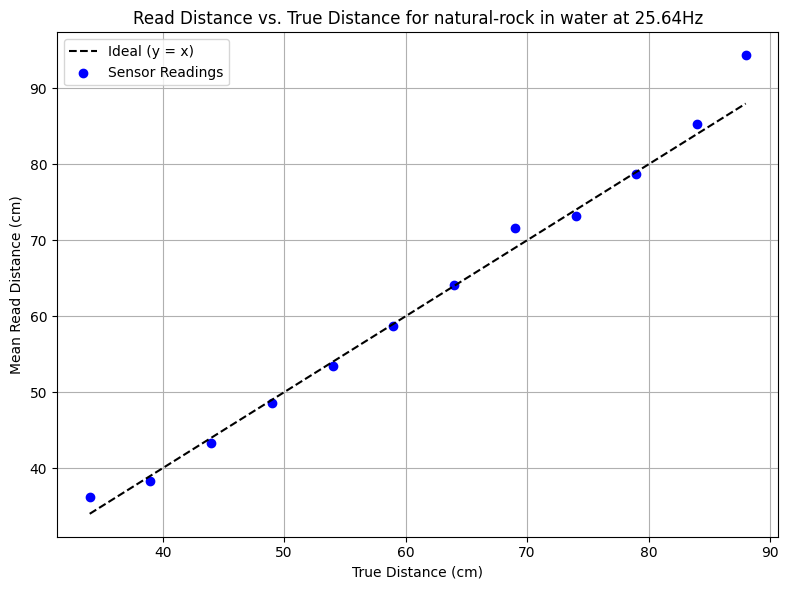

In [ ]:
# Graph 1: Read Distance vs True Distance
true_distances_cm = np.array(DISTANCES) / 10.0
mean_ranges_np = np.array(mean_ranges)

plt.figure(figsize=(8, 6))
plt.plot(true_distances_cm, true_distances_cm, 'k--', label="Ideal (y = x)")
plt.scatter(true_distances_cm, mean_ranges_np, color='blue', label="Sensor Readings")

plt.xlabel("True Distance (cm)")
plt.ylabel("Mean Read Distance (cm)")
plt.title("Read Distance vs. True Distance for " + f"{MATERIAL} in {MEDIUM} at {FREQ}Hz")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "read_vs_true_distance.png"))
plt.show()

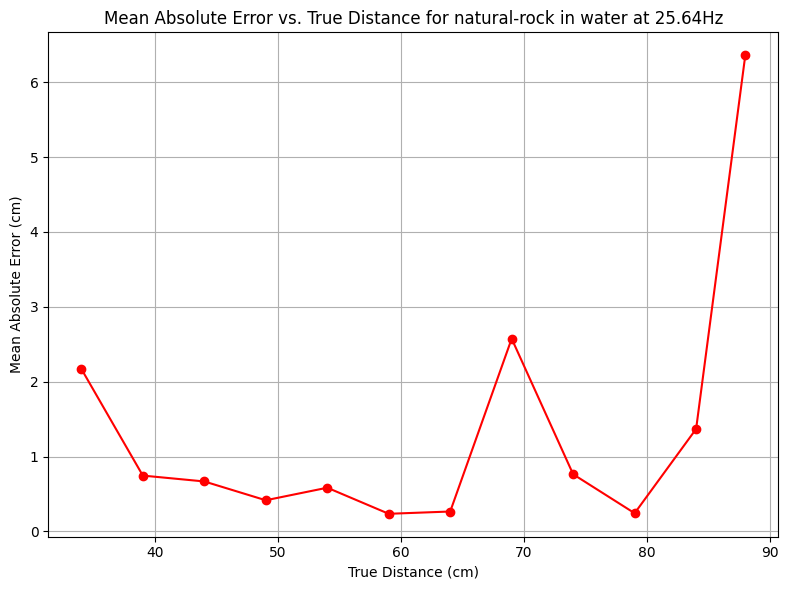

In [45]:
# Graph 2: Mean Absolute Error vs True Distance
abs_errors_np = np.array(absolute_differences)

plt.figure(figsize=(8, 6))
plt.plot(true_distances_cm, abs_errors_np, marker='o', color='red')

plt.xlabel("True Distance (cm)")
plt.ylabel("Mean Absolute Error (cm)")
plt.title("Mean Absolute Error vs. True Distance for " + f"{MATERIAL} in {MEDIUM} at {FREQ}Hz")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "absolute_error_vs_distance.png"))
plt.show()


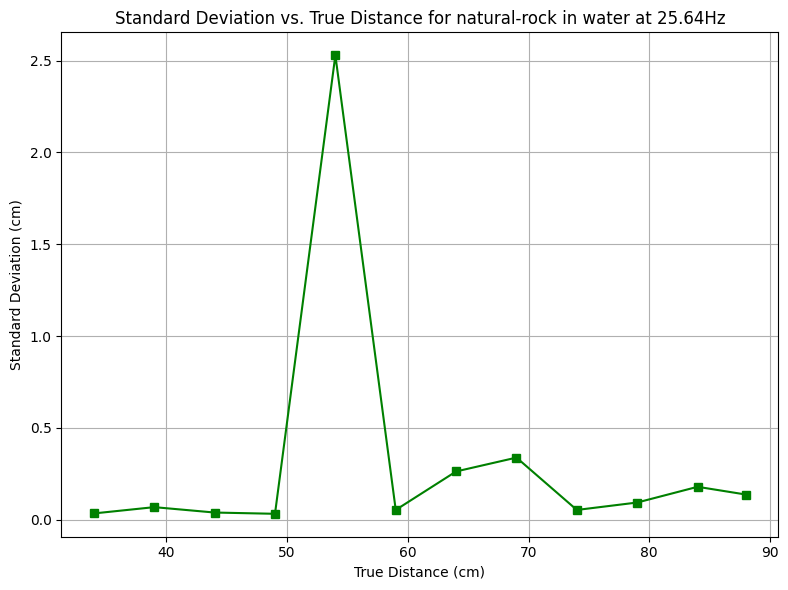

In [46]:
# Graph 3: Standard Deviation vs True Distance
std_devs_np = np.array(standard_deviations)

plt.figure(figsize=(8, 6))
plt.plot(true_distances_cm, std_devs_np, marker='s', color='green')

plt.xlabel("True Distance (cm)")
plt.ylabel("Standard Deviation (cm)")
plt.title("Standard Deviation vs. True Distance for " + f"{MATERIAL} in {MEDIUM} at {FREQ}Hz")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "std_dev_vs_distance.png"))
plt.show()
